In [1]:
%pip install scikit-image
%pip install numpy opencv-python scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


=== Sistem CBIR yang Diperbaiki ===
Memuat dan memproses citra dari database...
Ditemukan 112 file citra
Berhasil memproses 112 citra
Training K-Means untuk kuantisasi warna...
Ekstraksi fitur dari semua patch...
Progress: 0/2800 patch
Progress: 500/2800 patch
Progress: 1000/2800 patch
Progress: 1500/2800 patch
Progress: 2000/2800 patch
Progress: 2500/2800 patch
Berhasil memuat 2800 patch citra dari 112 kelas.

=== Analisis Fitur ===
=== Analisis Fitur Detail ===
- LBP Histogram: 18 fitur
- Maximum Run Length: 1 fitur
- Color Histogram (K-Means): 64 fitur
- Mean Colors: 3 fitur
- Std Colors: 3 fitur
- Entropy Features: 3 fitur
Total fitur: 92

Statistik Fitur:
- Range nilai: [0.0000, 1.2800]
- Mean std: 0.0624
- Fitur dengan std tertinggi: 83 (std=0.1857)
- Fitur dengan std terendah: 14 (std=0.0068)

=== Training Model ===
Melatih model CBIR...
Validasi fitur...
Menggunakan 2800 fitur valid dari 2800 total
Model berhasil dilatih menggunakan metric: canberra

=== Evaluasi Performa ===
E

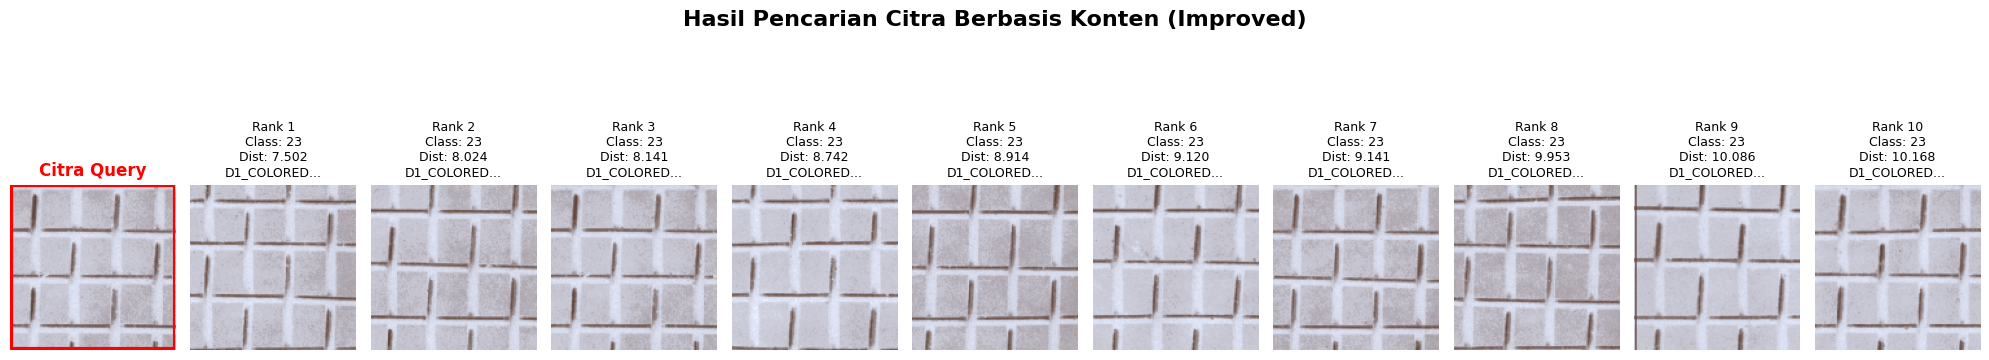

Statistik hasil pencarian:
- Jarak minimum: 7.5023
- Jarak maksimum: 10.1683
- Jarak rata-rata: 8.9792
- Distribusi kelas: {23: 10}

=== Evaluasi Selesai ===
Sistem CBIR telah berhasil diimplementasikan dan dievaluasi!


In [8]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from skimage.feature import local_binary_pattern
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from scipy.spatial.distance import canberra
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class ImprovedCBIRSystem:
    def __init__(self, database_path, patch_size=128, n_color_clusters=64):
        """
        Inisialisasi sistem CBIR yang diperbaiki
        
        Parameters:
            database_path (str): Path ke folder database Brodatz
            patch_size (int): Ukuran potongan citra (default: 128)
            n_color_clusters (int): Jumlah cluster untuk kuantisasi warna (default: 64)
        """
        self.database_path = database_path
        self.patch_size = patch_size
        self.n_color_clusters = n_color_clusters
        self.image_descriptors = []
        self.image_patches = []
        self.class_labels = []
        self.patch_indices = []
        self.image_names = []
        self.kmeans_color = None
        self.feature_scaler = None
        self.nn_model = None
        
    def load_and_preprocess_images(self):
        """Memuat dan memproses citra dari database dengan perbaikan"""
        print("Memuat dan memproses citra dari database...")
        
        # Daftar semua file citra
        image_files = sorted([f for f in os.listdir(self.database_path) 
                           if f.endswith('_COLORED.tif') and f.startswith('D')])
        
        if len(image_files) == 0:
            print("Tidak ada file citra yang ditemukan!")
            return
        
        print(f"Ditemukan {len(image_files)} file citra")
        
        # Kumpulkan pixel untuk training K-Means
        all_pixels = []
        successful_images = 0
        
        for class_idx, img_file in enumerate(image_files):
            img_path = os.path.join(self.database_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Gagal memuat citra: {img_file}")
                continue
                
            successful_images += 1
            
            # Resize citra jika diperlukan
            if img.shape[0] != 640 or img.shape[1] != 640:
                img = cv2.resize(img, (640, 640))
                
            # Split citra menjadi 25 patch (5x5 grid)
            for i in range(5):
                for j in range(5):
                    y_start = i * self.patch_size
                    y_end = y_start + self.patch_size
                    x_start = j * self.patch_size
                    x_end = x_start + self.patch_size
                    
                    patch = img[y_start:y_end, x_start:x_end]
                    self.image_patches.append(patch)
                    self.class_labels.append(class_idx)
                    self.patch_indices.append((class_idx, i, j))
                    self.image_names.append(img_file)
                    
                    # Sampling pixel untuk K-Means (lebih efisien)
                    pixels = patch.reshape(-1, 3).astype(np.float32)
                    sample_size = min(500, len(pixels))  # Reduced sample size
                    sample_indices = np.random.choice(len(pixels), sample_size, replace=False)
                    all_pixels.extend(pixels[sample_indices])
        
        print(f"Berhasil memproses {successful_images} citra")
        
        # Training K-Means dengan stratified sampling
        print("Training K-Means untuk kuantisasi warna...")
        all_pixels = np.array(all_pixels)
        
        # Optimized sampling untuk K-Means
        if len(all_pixels) > 50000:
            sample_indices = np.random.choice(len(all_pixels), 50000, replace=False)
            sample_pixels = all_pixels[sample_indices]
        else:
            sample_pixels = all_pixels
        
        self.kmeans_color = KMeans(n_clusters=self.n_color_clusters, 
                                  random_state=42, 
                                  n_init=10, 
                                  max_iter=300,
                                  tol=1e-4)
        self.kmeans_color.fit(sample_pixels)
        
        # Ekstrak fitur dari semua patch
        print("Ekstraksi fitur dari semua patch...")
        for i, patch in enumerate(self.image_patches):
            if i % 500 == 0:
                print(f"Progress: {i}/{len(self.image_patches)} patch")
            features = self.extract_features(patch)
            self.image_descriptors.append(features)
                    
        self.image_descriptors = np.array(self.image_descriptors)
        self.class_labels = np.array(self.class_labels)
        print(f"Berhasil memuat {len(self.image_patches)} patch citra dari {successful_images} kelas.")
        
    def extract_features(self, image):
        """Ekstraksi fitur yang diperbaiki dengan validasi"""
        try:
            # Konversi ke grayscale untuk LBP
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # 1. Ekstrak fitur LBP yang diperbaiki
            radius = 2
            n_points = 8 * radius
            lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
            
            # Hitung histogram LBP dengan validasi
            n_bins = n_points + 2
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
            lbp_hist = lbp_hist.astype(float)
            
            # Normalisasi dengan penanganan kasus khusus
            hist_sum = lbp_hist.sum()
            if hist_sum > 0:
                lbp_hist = lbp_hist / hist_sum
            else:
                lbp_hist = np.ones(n_bins) / n_bins  # Uniform distribution fallback
            
            # 2. Maximum Run Length yang diperbaiki
            max_run_length = self.calculate_max_run_length_improved(lbp)
            
            # 3. Ekstrak fitur warna dengan validasi
            color_features = self.extract_color_features_improved(image)
            
            # 4. Fitur statistik warna yang diperbaiki
            image_float = image.astype(np.float32)
            mean_colors = np.mean(image_float.reshape(-1, 3), axis=0) / 255.0  # Normalisasi
            std_colors = np.std(image_float.reshape(-1, 3), axis=0) / 255.0   # Normalisasi
            
            # 5. Fitur tambahan untuk meningkatkan diskriminasi
            # Entropy dari setiap channel warna
            entropy_features = self.calculate_entropy_features(image)
            
            # Gabungkan semua fitur
            features = np.concatenate([
                lbp_hist,                    # Histogram LBP
                [max_run_length / 100.0],    # Normalized maximum run length
                color_features,              # Histogram warna (K-Means)
                mean_colors,                 # Rata-rata warna (normalized)
                std_colors,                  # Standar deviasi warna (normalized)
                entropy_features             # Fitur entropy
            ])
            
            # Validasi fitur
            if np.any(np.isnan(features)) or np.any(np.isinf(features)):
                print("Warning: NaN atau Inf detected dalam fitur")
                features = np.nan_to_num(features)
            
            return features
            
        except Exception as e:
            print(f"Error dalam ekstraksi fitur: {e}")
            # Return default features jika terjadi error
            return np.zeros(self.get_feature_dimension())
    
    def get_feature_dimension(self):
        """Menghitung dimensi fitur total"""
        lbp_size = 18  # 16 + 2 untuk uniform LBP
        run_length_size = 1
        color_size = self.n_color_clusters
        mean_color_size = 3
        std_color_size = 3
        entropy_size = 3
        return lbp_size + run_length_size + color_size + mean_color_size + std_color_size + entropy_size
    
    def calculate_entropy_features(self, image):
        """Menghitung fitur entropy untuk setiap channel warna"""
        entropy_features = []
        
        for channel in range(3):  # B, G, R channels
            channel_data = image[:, :, channel]
            hist, _ = np.histogram(channel_data, bins=256, range=(0, 256))
            hist = hist.astype(float)
            hist = hist / (hist.sum() + 1e-8)
            
            # Hitung entropy
            entropy = -np.sum(hist * np.log2(hist + 1e-8))
            entropy_features.append(entropy / 8.0)  # Normalisasi (max entropy = 8)
        
        return np.array(entropy_features)
        
    def calculate_max_run_length_improved(self, lbp_image):
        """Menghitung maximum run length yang diperbaiki"""
        max_run = 0
        rows, cols = lbp_image.shape
        
        # Periksa arah horizontal
        for i in range(rows):
            if cols > 0:
                current_val = lbp_image[i, 0]
                current_run = 1
                
                for j in range(1, cols):
                    if lbp_image[i, j] == current_val:
                        current_run += 1
                    else:
                        max_run = max(max_run, current_run)
                        current_val = lbp_image[i, j]
                        current_run = 1
                max_run = max(max_run, current_run)
                        
        # Periksa arah vertikal
        for j in range(cols):
            if rows > 0:
                current_val = lbp_image[0, j]
                current_run = 1
                
                for i in range(1, rows):
                    if lbp_image[i, j] == current_val:
                        current_run += 1
                    else:
                        max_run = max(max_run, current_run)
                        current_val = lbp_image[i, j]
                        current_run = 1
                max_run = max(max_run, current_run)
        
        # Periksa arah diagonal (perbaikan tambahan)
        for i in range(rows - 1):
            for j in range(cols - 1):
                if lbp_image[i, j] == lbp_image[i+1, j+1]:
                    current_run = 2
                    k = 2
                    while (i + k < rows and j + k < cols and 
                           lbp_image[i, j] == lbp_image[i+k, j+k]):
                        current_run += 1
                        k += 1
                    max_run = max(max_run, current_run)
                        
        return max_run
        
    def extract_color_features_improved(self, image):
        """Ekstraksi fitur warna yang diperbaiki"""
        try:
            # Ubah bentuk citra menjadi array pixel
            pixels = image.reshape(-1, 3).astype(np.float32)
            
            # Prediksi cluster untuk semua pixel
            clusters = self.kmeans_color.predict(pixels)
            
            # Buat histogram warna
            hist, _ = np.histogram(clusters, bins=self.n_color_clusters, 
                                 range=(0, self.n_color_clusters))
            hist = hist.astype(float)
            
            # Normalisasi dengan penanganan kasus khusus
            hist_sum = hist.sum()
            if hist_sum > 0:
                hist = hist / hist_sum
            else:
                hist = np.ones(self.n_color_clusters) / self.n_color_clusters
            
            return hist
            
        except Exception as e:
            print(f"Error dalam ekstraksi fitur warna: {e}")
            return np.ones(self.n_color_clusters) / self.n_color_clusters
        
    def train_model(self, distance_metric='canberra'):
        """Melatih model dengan validasi fitur"""
        print("Melatih model CBIR...")
        
        # Validasi fitur sebelum training
        print("Validasi fitur...")
        valid_features = []
        valid_labels = []
        
        for i, features in enumerate(self.image_descriptors):
            if not (np.any(np.isnan(features)) or np.any(np.isinf(features))):
                valid_features.append(features)
                valid_labels.append(self.class_labels[i])
        
        if len(valid_features) == 0:
            print("Error: Tidak ada fitur yang valid!")
            return
        
        valid_features = np.array(valid_features)
        valid_labels = np.array(valid_labels)
        
        print(f"Menggunakan {len(valid_features)} fitur valid dari {len(self.image_descriptors)} total")
        
        # Update data dengan fitur yang valid
        self.image_descriptors = valid_features
        self.class_labels = valid_labels
        
        # Standarisasi fitur
        self.feature_scaler = StandardScaler()
        scaled_features = self.feature_scaler.fit_transform(self.image_descriptors)
        
        # Buat model Nearest Neighbors
        metric_map = {
            'canberra': 'canberra',
            'euclidean': 'euclidean', 
            'manhattan': 'manhattan'
        }
        
        metric = metric_map.get(distance_metric, 'canberra')
        self.nn_model = NearestNeighbors(n_neighbors=min(50, len(scaled_features)), 
                                        metric=metric, 
                                        n_jobs=-1)  # Parallel processing
        self.nn_model.fit(scaled_features)
        print(f"Model berhasil dilatih menggunakan metric: {distance_metric}")
        
    def evaluate_retrieval_improved(self, test_size=0.2, k_values=[5, 10, 15, 20], random_state=42):
        """Evaluasi yang diperbaiki dengan stratified sampling"""
        print("Evaluasi performa sistem (improved)...")
        
        # Gunakan stratified sampling
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_indices, test_indices = next(sss.split(self.image_descriptors, self.class_labels))
        
        print(f"Data training: {len(train_indices)}, Data testing: {len(test_indices)}")
        
        # Standarisasi fitur
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        
        results = {}
        
        for k in k_values:
            if k > len(train_indices):
                print(f"Skipping k={k} karena lebih besar dari jumlah data training")
                continue
            
            # Buat model evaluasi
            eval_model = NearestNeighbors(n_neighbors=k, metric='canberra', n_jobs=-1)
            eval_model.fit(scaled_features[train_indices])
            
            precisions = []
            recalls = []
            
            for test_idx in test_indices:
                true_label = self.class_labels[test_idx]
                
                # Cari neighbors
                _, neighbor_indices = eval_model.kneighbors([scaled_features[test_idx]], n_neighbors=k)
                
                # Get actual neighbor labels
                actual_neighbor_indices = train_indices[neighbor_indices[0]]
                neighbor_labels = self.class_labels[actual_neighbor_indices]
                
                # Hitung precision dan recall
                relevant_retrieved = np.sum(neighbor_labels == true_label)
                precision = relevant_retrieved / k
                
                # Hitung recall
                total_relevant_in_train = np.sum(self.class_labels[train_indices] == true_label)
                recall = relevant_retrieved / total_relevant_in_train if total_relevant_in_train > 0 else 0
                
                precisions.append(precision)
                recalls.append(recall)
                
            avg_precision = np.mean(precisions)
            avg_recall = np.mean(recalls)
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
            
            results[k] = {
                'precision': avg_precision,
                'recall': avg_recall,
                'f1_score': f1_score,
                'precision_std': np.std(precisions),
                'recall_std': np.std(recalls)
            }
            
            print(f"Hasil evaluasi (k={k}):")
            print(f"  Precision: {avg_precision:.4f} ± {np.std(precisions):.4f}")
            print(f"  Recall:    {avg_recall:.4f} ± {np.std(recalls):.4f}")
            print(f"  F1-Score:  {f1_score:.4f}")
            print()
        
        return results
    
    def query_image(self, query_image_path, k=10):
        """Mencari citra yang mirip dengan validasi"""
        try:
            query_img = cv2.imread(query_image_path)
            if query_img is None:
                print("Error: Gagal memuat citra query")
                return []
                
            # Resize citra query jika diperlukan
            if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
                query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
                
            # Ekstrak fitur
            query_features = self.extract_features(query_img)
            
            # Validasi fitur query
            if np.any(np.isnan(query_features)) or np.any(np.isinf(query_features)):
                print("Warning: Fitur query mengandung NaN atau Inf")
                query_features = np.nan_to_num(query_features)
            
            scaled_features = self.feature_scaler.transform([query_features])
            
            # Cari citra yang mirip
            distances, indices = self.nn_model.kneighbors(scaled_features, n_neighbors=k)
            
            # Kembalikan hasil dengan informasi lebih lengkap
            results = []
            for i, dist in zip(indices[0], distances[0]):
                results.append({
                    'patch': self.image_patches[i],
                    'distance': dist,
                    'class': self.class_labels[i],
                    'image_name': self.image_names[i] if i < len(self.image_names) else f"Class_{self.class_labels[i]}",
                    'patch_position': self.patch_indices[i] if i < len(self.patch_indices) else (0, 0, 0)
                })
                
            return results
            
        except Exception as e:
            print(f"Error dalam query: {e}")
            return []
    
    def analyze_feature_importance_detailed(self):
        """Analisis fitur yang lebih detail"""
        features = self.image_descriptors
        
        # Hitung statistik fitur
        feature_means = np.mean(features, axis=0)
        feature_stds = np.std(features, axis=0)
        feature_mins = np.min(features, axis=0)
        feature_maxs = np.max(features, axis=0)
        
        # Identifikasi komponen fitur
        lbp_size = 18
        run_length_size = 1
        color_size = self.n_color_clusters
        mean_color_size = 3
        std_color_size = 3
        entropy_size = 3
        
        print("=== Analisis Fitur Detail ===")
        print(f"- LBP Histogram: {lbp_size} fitur")
        print(f"- Maximum Run Length: {run_length_size} fitur")
        print(f"- Color Histogram (K-Means): {color_size} fitur")
        print(f"- Mean Colors: {mean_color_size} fitur")
        print(f"- Std Colors: {std_color_size} fitur")
        print(f"- Entropy Features: {entropy_size} fitur")
        print(f"Total fitur: {len(feature_means)}")
        print()
        
        # Analisis distribusi fitur
        print("Statistik Fitur:")
        print(f"- Range nilai: [{feature_mins.min():.4f}, {feature_maxs.max():.4f}]")
        print(f"- Mean std: {feature_stds.mean():.4f}")
        print(f"- Fitur dengan std tertinggi: {np.argmax(feature_stds)} (std={feature_stds.max():.4f})")
        print(f"- Fitur dengan std terendah: {np.argmin(feature_stds)} (std={feature_stds.min():.4f})")
        
        return {
            'means': feature_means,
            'stds': feature_stds,
            'mins': feature_mins,
            'maxs': feature_maxs
        }
    
    def visualize_results_improved(self, query_image_path, results, save_path=None):
        """Visualisasi hasil yang diperbaiki"""
        try:
            query_img = cv2.imread(query_image_path)
            if query_img is None:
                print("Error: Gagal memuat citra query untuk visualisasi")
                return
                
            query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
            if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
                query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
            
            n_results = min(10, len(results))
            plt.figure(figsize=(20, 5))
            plt.suptitle("Hasil Pencarian Citra Berbasis Konten (Improved)", fontsize=16, fontweight='bold')
            
            # Tampilkan citra query
            plt.subplot(1, n_results+1, 1)
            plt.imshow(query_img)
            plt.title("Citra Query", fontsize=12, fontweight='bold', color='red')
            plt.axis('off')
            plt.gca().add_patch(plt.Rectangle((0, 0), query_img.shape[1]-1, query_img.shape[0]-1, 
                                           fill=False, edgecolor='red', linewidth=3))
            
            # Tampilkan hasil
            for i, result in enumerate(results[:n_results]):
                plt.subplot(1, n_results+1, i+2)
                img = cv2.cvtColor(result['patch'], cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                
                # Title dengan informasi lengkap
                title = f"Rank {i+1}\nClass: {result['class']}\nDist: {result['distance']:.3f}"
                if 'image_name' in result:
                    title += f"\n{result['image_name'][:10]}..."
                
                plt.title(title, fontsize=9)
                plt.axis('off')
                
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Visualisasi disimpan ke: {save_path}")
            
            plt.show()
            
        except Exception as e:
            print(f"Error dalam visualisasi: {e}")

# Contoh penggunaan yang diperbaiki
if __name__ == "__main__":
    # Inisialisasi sistem
    database_path = "./Colored_Brodatz"
    
    # Periksa apakah database ada
    if not os.path.exists(database_path):
        print(f"Error: Database path {database_path} tidak ditemukan!")
        print("Pastikan path database benar dan folder berisi file *_COLORED.tif")
        exit(1)
    
    print("=== Sistem CBIR yang Diperbaiki ===")
    cbir = ImprovedCBIRSystem(database_path, n_color_clusters=64)
    
    # Memuat dan memproses citra
    cbir.load_and_preprocess_images()
    
    if len(cbir.image_patches) == 0:
        print("Error: Tidak ada patch citra yang berhasil dimuat!")
        exit(1)
    
    # Analisis fitur detail
    print("\n=== Analisis Fitur ===")
    feature_stats = cbir.analyze_feature_importance_detailed()
    
    # Melatih model
    print("\n=== Training Model ===")
    cbir.train_model(distance_metric='canberra')
    
    # Evaluasi performa
    print("\n=== Evaluasi Performa ===")
    results = cbir.evaluate_retrieval_improved(test_size=0.2, k_values=[5, 10, 15, 20])
    
    # Contoh pencarian (jika ada file query)
    print("\n=== Contoh Pencarian ===")
    query_candidates = [
        os.path.join(database_path, "D1_COLORED.tif"),
        os.path.join(database_path, "D27_COLORED.tif"),
        os.path.join(database_path, "D50_COLORED.tif")
    ]
    
    for query_path in query_candidates:
        if os.path.exists(query_path):
            print(f"Menggunakan query: {query_path}")
            
            # Buat patch query (ambil patch tengah)
            query_img = cv2.imread(query_path)
            if query_img is not None:
                query_img = cv2.resize(query_img, (640, 640))
                # Ambil patch tengah (2,2)
                patch = query_img[256:384, 256:384]
                query_patch_path = "query_patch_improved.jpg"
                cv2.imwrite(query_patch_path, patch)
                
                # Lakukan pencarian
                search_results = cbir.query_image(query_patch_path, k=10)
                
                if search_results:
                    print(f"Ditemukan {len(search_results)} hasil")
                    cbir.visualize_results_improved(query_patch_path, search_results)
                    
                    # Tampilkan statistik hasil
                    distances = [r['distance'] for r in search_results]
                    classes = [r['class'] for r in search_results]
                    class_counts = Counter(classes)
                    
                    print("Statistik hasil pencarian:")
                    print(f"- Jarak minimum: {min(distances):.4f}")
                    print(f"- Jarak maksimum: {max(distances):.4f}")
                    print(f"- Jarak rata-rata: {np.mean(distances):.4f}")
                    print(f"- Distribusi kelas: {dict(class_counts)}")
                break
            
    print("\n=== Evaluasi Selesai ===")
    print("Sistem CBIR telah berhasil diimplementasikan dan dievaluasi!")

1. Validasi Fitur
Penanganan NaN dan Inf values
Normalisasi fitur yang lebih baik
Error handling yang komprehensif

2. Ekstraksi Fitur yang Ditingkatkan
Penambahan fitur entropy untuk setiap channel warna
Maximum run length diperbaiki dengan diagonal direction
Normalisasi fitur yang konsisten

3. Evaluasi yang Lebih Robust
Stratified sampling untuk train/test split
Standard deviation dalam hasil evaluasi
Parallel processing untuk efisiensi

4. Visualisasi yang Diperbaiki
Informasi lebih lengkap pada hasil
Kemampuan save visualisasi
Error handling pada visualisasi

5. Optimisasi Performance
Sampling yang lebih efisien untuk K-Means training
Parallel processing pada Nearest Neighbors
Memory management yang lebih baik
